In [ ]:
# preliminary-analysis-2024-speed-bursts.ipynb
#
# Bryan Daniels
# 2024/5/23
#
# Can bursts of speed by individual bees be connected to comb-building?
#
# Builds from preliminary-analysis-2024-comb-building.ipynb
#

In [1]:
import pandas as pd
import numpy as np
import pickle, gzip
import matplotlib.pyplot as plt
%matplotlib inline
from toolbox import defaultFigure
defaultFigure.setDefaultParams()
from toolbox import gifsicle
from importlib import reload  
import random
import cProfile
from tqdm import tqdm

In [2]:
# import stuff from jacob davidson's github repository: https://github.com/jacobdavidson/bees_drones_2019data
from bees_drones_2019data import displayfunctions as bp  # 'bee plots'
from bees_drones_2019data import datafunctions as dfunc
from bees_drones_2019data import definitions_2019 as bd
dfunc.init(bd) 
bp.init(bd)
bd.year

2019

In [196]:
import time_functions_2019 as tf
import trajectory_analysis as traj

# Load data

The days with festoons are roughly (1) between day 4 and 20 and (2) between day 46 and 65

In [7]:
days_to_load = np.arange(0,10) #[4,]

## Load 5-minute behavioral data

In [3]:
# data from 2019: https://zenodo.org/records/7298798
behavioral_data_dir = '../Data/240329/df_day5min/'

In [8]:
dfList = [ pd.read_hdf('{}df_day5min_{:03d}.hdf'.format(behavioral_data_dir,daynum)) for daynum in days_to_load ]
dfFiveMinute = pd.concat(dfList)

In [102]:
# deal with cohort information

# add cohort names to the dataframe
dfFiveMinute['Cohort name'] = [ bd.cohort_names[int(cid)] for cid in dfFiveMinute['Cohort ID'] ]

# define mapping from bee id to cohort name
bee_cohort_dict = dict([ (int(uid),dfFiveMinute[dfFiveMinute['Bee unique ID']==uid]['Cohort name'].iloc[0]) \
                         for uid in dfFiveMinute['Bee unique ID'].unique() ])

In [47]:
divisions_per_day_five_min = 24*60/5

## Load trajectory data

In [194]:
trajectory_days_to_load = [4,]

# data from 2019: https://zenodo.org/records/7298798
trajectory_data_dir = '../Data/231018/trajectories_000-019/'

filenames = [ '{}beetrajectories_{:03d}.hdf'.format(trajectory_data_dir,daynum) for daynum in trajectory_days_to_load ]
dfTraj = pd.concat(map(pd.read_hdf,filenames))

# time conversion
frames_per_second = 3
frames_per_day = 24*60*60*frames_per_second
dfTraj['Time (days)'] = dfTraj['daynum'] + dfTraj['framenum']/frames_per_day

print("Trajectories use {:.1f} GB of memory.".format(dfTraj.memory_usage().sum()/1e9))

Trajectories use 8.2 GB of memory.


In [197]:
# takes ~30 seconds to add speed data to all trajectories from a single day
traj.add_speed_data(dfTraj)

# Find speed bursts

## at 5 minute resolution

As computed in the section `Data processing to calculate metrics` in `Data processing - 1 - metrics and dataframes.ipynb`, speeds in `dfFiveMinutes` are in units of pixels per second.  Observations separated by >1 second are filtered out.

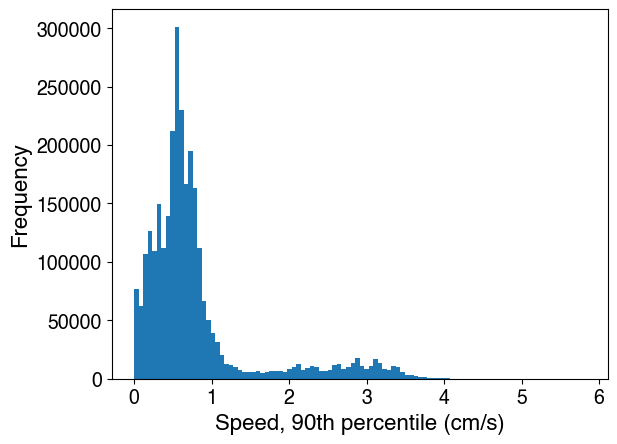

In [10]:
pixels_per_cm = 80
(dfFiveMinute['Speed 90th quantile']/pixels_per_cm).plot.hist(bins=100)
plt.xlabel('Speed, 90th percentile (cm/s)');

In [14]:
# We will define speed bursts for now as 90th percentile speed > 1.5 cm/s
speed_thresh_cmps = 1.5 # cm/s
speed_thresh = speed_thresh_cmps * pixels_per_cm # pixels/s

In [214]:
def state_matrix(df,col,divisions_per_day,df_type='behavioral'):
    """
    Takes a dataframe with specific columns, depending on `df_type`:
      - `Bee unique ID`, `Day number`, and `timedivision` if df_type = 'behavioral' (e.g. from a `df_day5min` file)
      - `uid`, `daynum`, `framenum` if df_type = 'trajectory' (e.g. from a `beetrajectories` file)
    
    Returns a dataframe indexed by bee id and with columns corresponding to time, with each element
    corresponding to the column `col` of the input dataframe.

    A given time division is included if (and only if) any data are available for that time division.
    A given bee is included if (and only if) any data are available for that bee at any time.

    divisions_per_day              : number of time divisions per day.  For df_type = 'trajectory',
                                     this should typically be 24*60*60*3 = 259200 (for 3 frames per second)
    df_type ('behavioral')         : 'behavioral' or 'trajectory'
    """
    assert(type(col)==str)

    if df_type == 'behavioral':
        daycolumn = 'Day number'
        beecolumn = 'Bee unique ID'
        timecolumn = 'timedivision'
    elif df_type == 'trajectory':
        daycolumn = 'daynum'
        beecolumn = 'uid'
        timecolumn = 'framenum'
    else:
        raise(Exception,'Unrecognized df_type: {}'.format(df_type))
    
    # we will build lists of times and column_data
    column_data_list,times = [],[]
    
    days = df[daycolumn].unique()
    days.sort()
    # loop over days
    for daynum in days:
        df_day = df[df[daycolumn]==daynum]
        timedivisions = df_day[timecolumn].unique()
        timedivisions.sort()
        # loop over time divisions within a given day
        for timedivision in timedivisions:
            df_day_time = df_day[df_day[timecolumn]==timedivision]
            
            # construct column of data for the given time
            column_data_list.append( df_day_time.set_index(beecolumn)[col] )

            # convert time division to an absolute time
            times.append(tf.timediv_to_datetime(int(daynum),timedivision,divisions_per_day))
            
    return pd.DataFrame(column_data_list,index=times).T

In [211]:
# Make binary state matrix (bee x timedivision)
speed_mat = state_matrix(dfFiveMinute,'Speed 90th quantile',divisions_per_day_five_min)

In [212]:
speed_mat

2019-06-05 00:00:00  2019-06-05 00:05:00  2019-06-05 00:10:00  \
Bee unique ID                                                                  
4.0                            NaN                  NaN                  NaN   
6.0                            NaN                  NaN                  NaN   
7.0                            NaN                  NaN                  NaN   
9.0                            NaN                  NaN                  NaN   
11.0                           NaN                  NaN                  NaN   
...                            ...                  ...                  ...   
2620.0                         NaN                  NaN                  NaN   
2621.0                         NaN                  NaN                  NaN   
2622.0                         NaN                  NaN                  NaN   
2623.0                         NaN                  NaN                  NaN   
2527.0                         NaN                  NaN                  NaN   

               2019-06-05 00:15:00  2019-06-05 00:20:00  2019-06-05 00:25:00  \
Bee unique ID                                                                  
4.0                            NaN                  NaN                  NaN   
6.0                            NaN                  NaN                  NaN   
7.0                            NaN                  NaN                  NaN   
9.0                            NaN                  NaN                  NaN   
11.0                           NaN                  NaN                  NaN   
...                            ...                  ...                  ...   
2620.0                         NaN                  NaN                  NaN   
2621.0                         NaN                  NaN                  NaN   
2622.0                         NaN                  NaN                  NaN   
2623.0                         NaN                  NaN                  NaN   
2527.0                         NaN                  NaN                  NaN   

               2019-06-05 00:30:00  2019-06-05 00:35:00  2019-06-05 00:40:00  \
Bee unique ID                                                                  
4.0                            NaN                  NaN                  NaN   
6.0                            NaN                  NaN                  NaN   
7.0                            NaN                  NaN                  NaN   
9.0                            NaN                  NaN                  NaN   
11.0                           NaN                  NaN                  NaN   
...                            ...                  ...                  ...   
2620.0                         NaN                  NaN                  NaN   
2621.0                         NaN                  NaN                  NaN   
2622.0                         NaN                  NaN                  NaN   
2623.0                         NaN                  NaN                  NaN   
2527.0                         NaN                  NaN                  NaN   

               2019-06-05 00:45:00  ...  2019-06-14 23:10:00  \
Bee unique ID                       ...                        
4.0                            NaN  ...                  NaN   
6.0                            NaN  ...                  NaN   
7.0                            NaN  ...            57.078893   
9.0                            NaN  ...                  NaN   
11.0                           NaN  ...                  NaN   
...                            ...  ...                  ...   
2620.0                         NaN  ...                  NaN   
2621.0                         NaN  ...             4.242641   
2622.0                         NaN  ...             3.000000   
2623.0                         NaN  ...             9.000000   
2527.0                         NaN  ...            34.484868   

               2019-06-14 23:15:00  2019-06-14 23:20:00  20

In [111]:
# limit to non-drone bees
non_drone_cohorts = [ name for name in bd.cohort_names if not name.endswith('_drones') ]
non_drone_bees = [ uid for uid in bee_cohort_dict \
                   if bee_cohort_dict[uid] in non_drone_cohorts ]
print("Out of {} total bees, {} come from non-drone cohorts.".format(len(bee_cohort_dict),len(non_drone_bees)))

Out of 2056 total bees, 1864 come from non-drone cohorts.


In [ ]:
# TO DO:
# - color NaN differently than False in the below plot
# - are the quiescent vertical stripes to be believed?
# - put start of comb-building festoon on this plot
# - (do we need to look at data with finer time resolution, e.g. 1 minute?)
# - do bees just starting to festoon have a recent history of higher speeds?

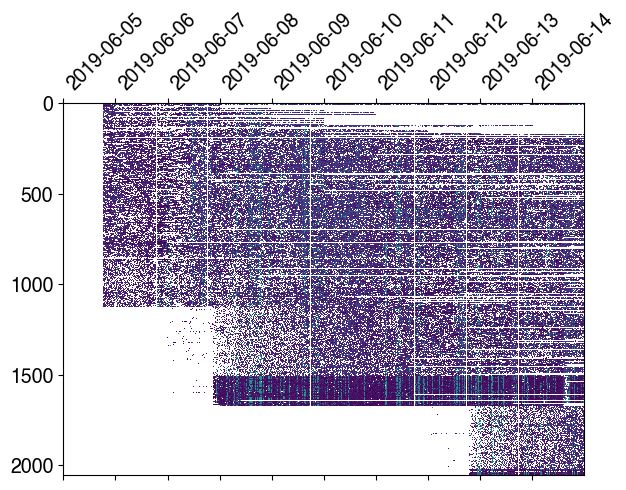

In [160]:
plt.matshow(speed_mat)
skipx = 288 # 288 corresponds to ticks at midnight each day
plt.xticks(range(speed_mat.shape[1])[::skipx], 
           [t.date() for t in speed_mat.columns[::skipx]],rotation=45,ha='left');

In [184]:
fig = plt.figure(figsize=(10,7),dpi=1000)

# show binarized speed matrix
m = speed_mat.loc[non_drone_bees]>speed_thresh
plt.matshow(m,fignum=fig.number)
divisions_per_day = int(divisions_per_day_five_min)
skipx = divisions_per_day # corresponds to ticks at midnight each day
plt.xticks(range(m.shape[1])[::skipx], 
           [t.date() for t in m.columns[::skipx]],rotation=45,ha='left');

# draw vertical lines corresponding to festoon start
just_before_festoon_start,just_after_festoon_start = 4.60,4.65 # days (see preliminary-analysis-2024-comb-building.ipynb)
plt.vlines(just_before_festoon_start*divisions_per_day,0,m.shape[0],color='w',lw=0.5)
plt.vlines(just_after_festoon_start*divisions_per_day,0,m.shape[0],color='w',lw=0.5)
plt.axis(ymin=m.shape[0],ymax=0)

plt.subplots_adjust(bottom=0.05,top=0.5)
plt.savefig('240524_preliminary_speed_burst_data.pdf')

In [188]:
# convert festoon start time to datetime format
festoon_start_daynum = 4
just_before_festoon_start_datetime = tf.timediv_to_datetime(festoon_start_daynum,
                       (just_before_festoon_start-festoon_start_daynum)*divisions_per_day,
                       divisions_per_day)
just_after_festoon_start_datetime = tf.timediv_to_datetime(festoon_start_daynum,
                       (just_after_festoon_start-festoon_start_daynum)*divisions_per_day,
                       divisions_per_day)

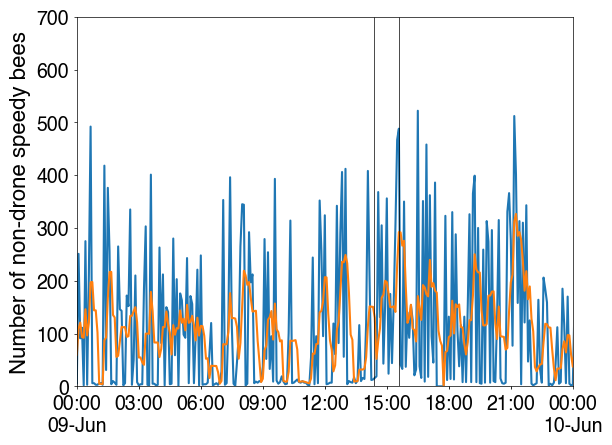

In [192]:
# plot speed sum and rolling average speed sum
(speed_mat.loc[non_drone_bees]>speed_thresh).sum(axis=0).plot()
(speed_mat.loc[non_drone_bees]>speed_thresh).sum(axis=0).rolling(5).mean().plot()

# vertical lines at festoon start
plt.vlines(just_before_festoon_start_datetime,0,700,color='k',lw=0.5)
plt.vlines(just_after_festoon_start_datetime, 0,700,color='k',lw=0.5)
plt.axis(ymin=0,ymax=700)

# fiddle with plot
plt.ylabel('Number of non-drone speedy bees')
plt.axis(xmin=speed_mat.columns[288*4],xmax=speed_mat.columns[288*5])
defaultFigure.makePretty()

In [12]:
# restrict to bees that at some point join the festoon
festoon_sum = dfFiveMinute.groupby('Bee unique ID').sum()['Festoon']
festooner_bees = [ int(uid) for uid in festoon_sum[festoon_sum > 0].index ]
dfFiveMinute_festooners = dfFiveMinute[dfFiveMinute['Bee unique ID'].isin(festooner_bees)]
print("There are {} bees that festoon at some point, out of a total {} bees.".format(len(festooner_bees),
                                                                                     len(dfFiveMinute['Bee unique ID'].unique())))

There are 1595 bees that festoon at some point, out of a total 2056 bees.


## at 3 frames per second resolution

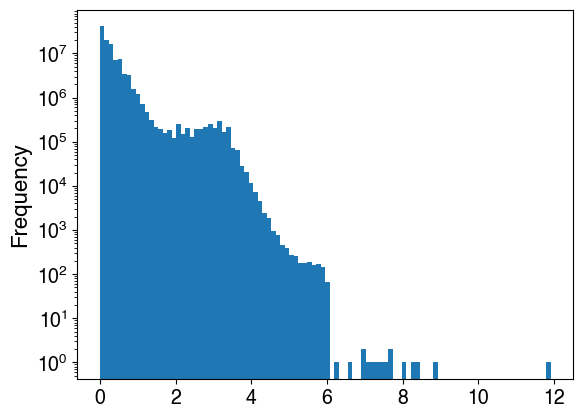

In [201]:
dfTraj['speed (cm/s)'].plot.hist(bins=100)
plt.yscale('log')

### restricted time frame near festoon start

In [249]:
minTimeDays = 4.6007 #4.6   # start of time window in days
deltaTimeHours = 0.5 #2 # duration of time window in hours

# time conversions
daynum = int(np.floor(minTimeDays))
dayStartTime = tf.timediv_to_datetime(daynum,0,divisions_per_day)
minTime = dayStartTime + dt.timedelta(days=minTimeDays-daynum)
maxTime = minTime + dt.timedelta(hours=deltaTimeHours)
maxTimeDays = tf.datetime_to_daynum(maxTime) + tf.seconds_past_midnight(maxTime)/(24*60*60)
minTime_frame = tf.datetime_to_framenum(minTime)
maxTime_frame = tf.datetime_to_framenum(maxTime)

# calculate restricted dataframes
#dfFiveMinute_windowed = dfFiveMinute[(dfFiveMinute['Time (days)'] > minTimeDays) & (dfFiveMinute['Time (days)'] < maxTimeDays)]
dfTraj_windowed = dfTraj[(dfTraj['daynum']==daynum) & (dfTraj['framenum'] < maxTime_frame) & (dfTraj['framenum'] > minTime_frame)]

print("Restricting to time window starting at {} and ending at {}.".format(minTime,maxTime))

Restricting to time window starting at 2019-06-09 14:25:00.480000 and ending at 2019-06-09 14:55:00.480000.


In [250]:
# Make binary state matrix (bee x timedivision)
# (takes ~ 2 minutes for 2 hours of trajectory data at 3 fps)
divisions_per_day_frames = 24*60*60*3
speed_mat_frames = state_matrix(dfTraj_windowed,'speed (cm/s)',divisions_per_day_frames,df_type='trajectory')

In [347]:
# Make binary state matrix (bee x timedivision) for delta x and delta y
# (need to restrict to only frames in which we have speed data)
divisions_per_day_frames = 24*60*60*3
dfTraj_windowed_filtered = dfTraj_windowed[~dfTraj_windowed['speed (cm/s)'].isna()]
speed_mat_frames_delta_y = state_matrix(dfTraj_windowed_filtered,'delta y',divisions_per_day_frames,df_type='trajectory')
speed_mat_frames_delta_x = state_matrix(dfTraj_windowed_filtered,'delta x',divisions_per_day_frames,df_type='trajectory')

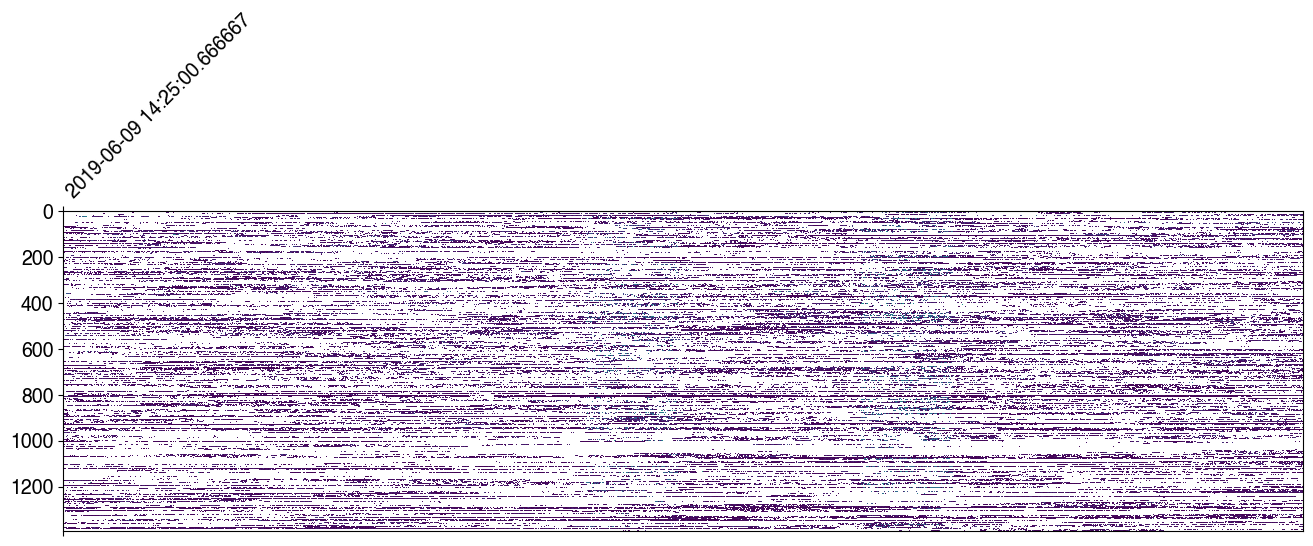

In [254]:
non_drone_bees_in_speed_mat = np.sort(list(set(non_drone_bees).intersection(speed_mat_frames.index)))

plt.matshow(speed_mat_frames.loc[non_drone_bees_in_speed_mat])
skipx = 10800 # 3*60*60 = 10800 corresponds to ticks one hour apart
plt.xticks(range(speed_mat_frames.shape[1])[::skipx], 
           [t for t in speed_mat_frames.columns[::skipx]],rotation=45,ha='left');

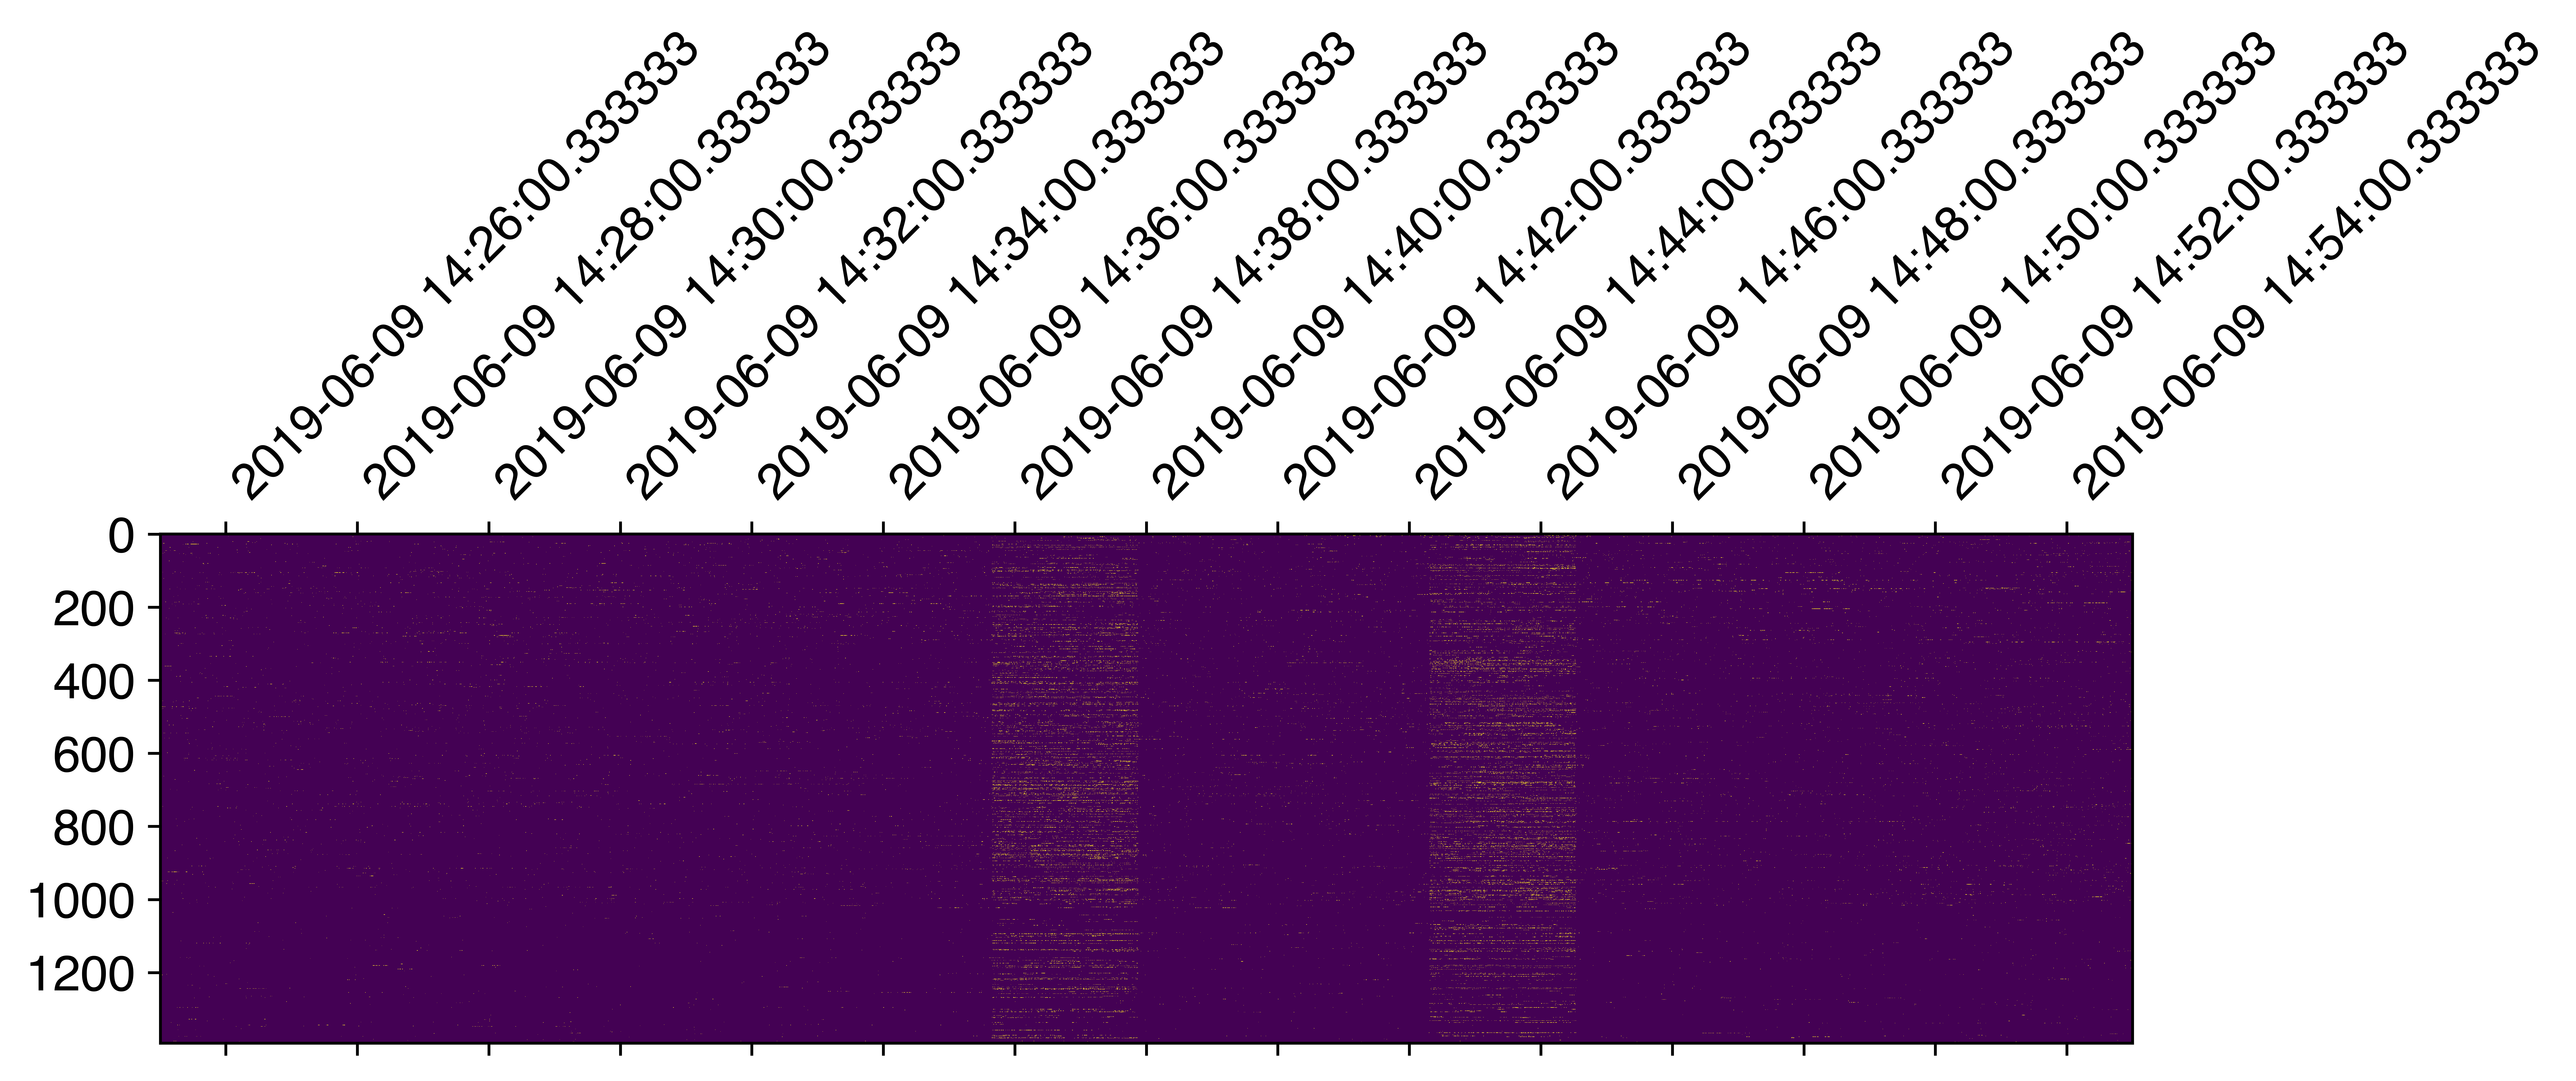

In [264]:
fig = plt.figure(figsize=(10,7),dpi=1000)

speed_thresh_frames = 1.5 # cm/s

# show binarized speed matrix
non_drone_bees_in_speed_mat = np.sort(list(set(non_drone_bees).intersection(speed_mat_frames.index)))
m = speed_mat_frames.loc[non_drone_bees_in_speed_mat]>speed_thresh_frames
plt.matshow(m,fignum=fig.number)
divisions_per_day = int(divisions_per_day_frames)
offsetx = 2 + 59*3 # offset to put first tick at a five minute mark
skipx = divisions_per_day_frames//24//(60//2) # corresponds to ticks every two minutes
plt.xticks(range(m.shape[1])[offsetx::skipx], 
           [t for t in m.columns[offsetx::skipx]],rotation=45,ha='left');

plt.subplots_adjust(bottom=0.05,top=0.5)
plt.savefig('240528_preliminary_speed_burst_data_frames.pdf')

(18056.599660879634, 18056.62256905864, 210.0, 552.9020247092429)

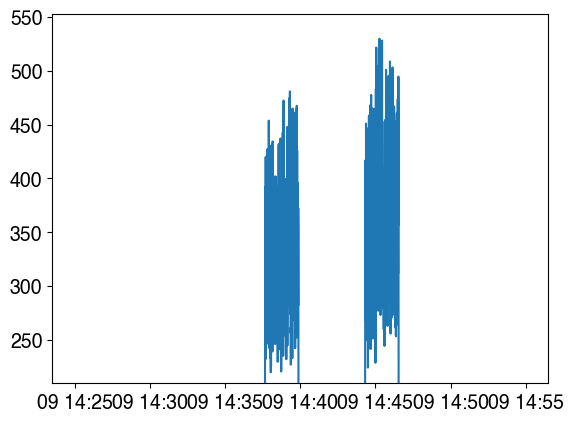

In [290]:
plt.plot(speed_mat_frames.sum(axis=0))
plt.axis(ymin=210)

In [294]:
# find transition points
summed_speeds = speed_mat_frames.sum(axis=0)
transition_points = list(summed_speeds.index[np.where(np.diff(summed_speeds > 210))])

In [296]:
np.diff(transition_points)

array([Timedelta('0 days 00:02:13.666667'), Timedelta('0 days 00:04:26'),
       Timedelta('0 days 00:02:13.666666')], dtype=object)

In [298]:
(2*60+13.666666)*3

400.999998

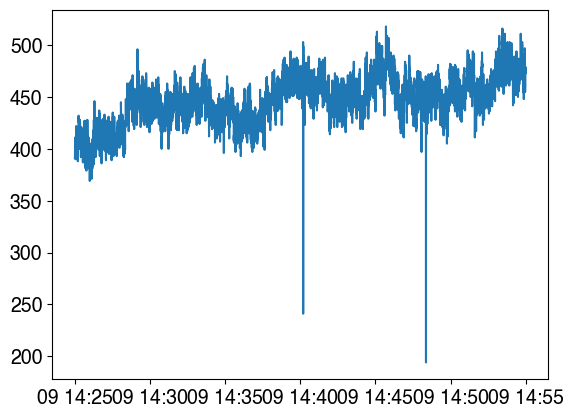

In [259]:
plt.plot(speed_mat_frames.count())

In [275]:
# compare behavior during burst time to non-burst time
nonbursttime = speed_mat_frames.columns[1798]     # 2019-06-09 14:35:00
bursttime = speed_mat_frames.columns[1798+3*60*3] # 2019-06-09 14:38:00

<Axes: ylabel='Frequency'>

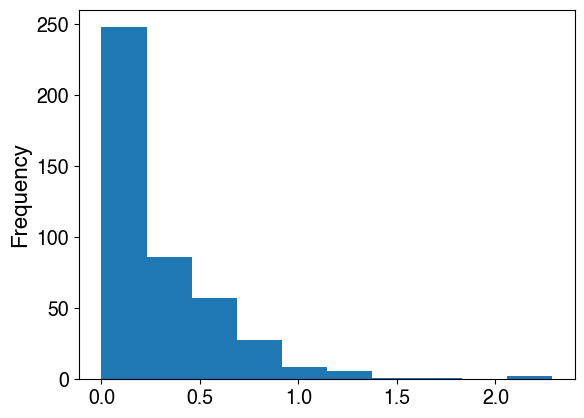

In [277]:
speed_mat_frames[nonbursttime].plot.hist()

<Axes: ylabel='Frequency'>

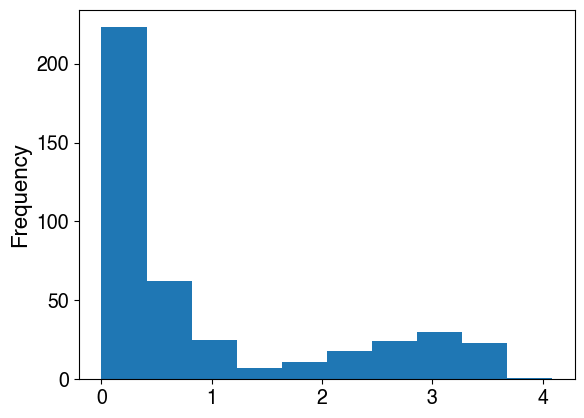

In [278]:
speed_mat_frames[bursttime].plot.hist()

<Axes: ylabel='Frequency'>

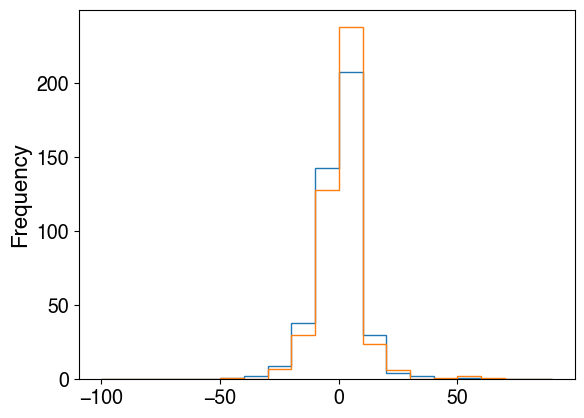

In [354]:
bins = np.arange(-100,100,10)
speed_mat_frames_delta_x[nonbursttime].plot.hist(histtype='step',bins=bins)
speed_mat_frames_delta_y[nonbursttime].plot.hist(histtype='step',bins=bins)

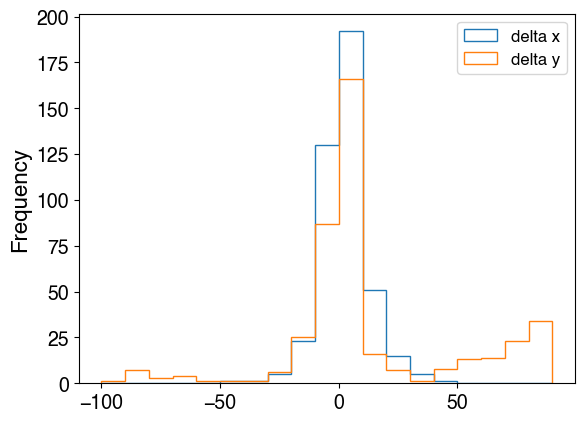

In [353]:
bins = np.arange(-100,100,10)
speed_mat_frames_delta_x[bursttime].plot.hist(histtype='step',label='delta x',bins=bins)
speed_mat_frames_delta_y[bursttime].plot.hist(histtype='step',label='delta y',bins=bins)
plt.legend()

In [303]:
# are only a subset of bees involved?
np.sum(np.sum(speed_mat_frames > speed_thresh_frames,axis=1)>0)

1365

In [304]:
len(speed_mat_frames.index)

1545

Text(0, 0.5, 'Number of bees')

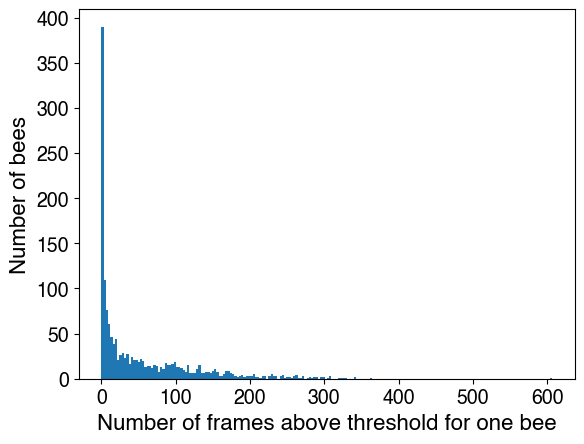

In [314]:
num_frames_above_thresh = np.sum(speed_mat_frames > speed_thresh_frames,axis=1)
num_frames_above_thresh.plot.hist(bins=200)
plt.xlabel('Number of frames above threshold for one bee')
plt.ylabel('Number of bees')

In [319]:
# call bees fast if they are above threshold in > 100 frames (one burst is 400 frames long)
fast_bees = num_frames_above_thresh[num_frames_above_thresh > 100].index

In [323]:
fast_bees

Index([ 415,  577,  612,  623,  644,  714,  756,  816,  835,  847,
       ...
        554, 1384, 1358,  591, 1994, 2065, 1245, 1467, 1703, 2018],
      dtype='int64', name='uid', length=318)

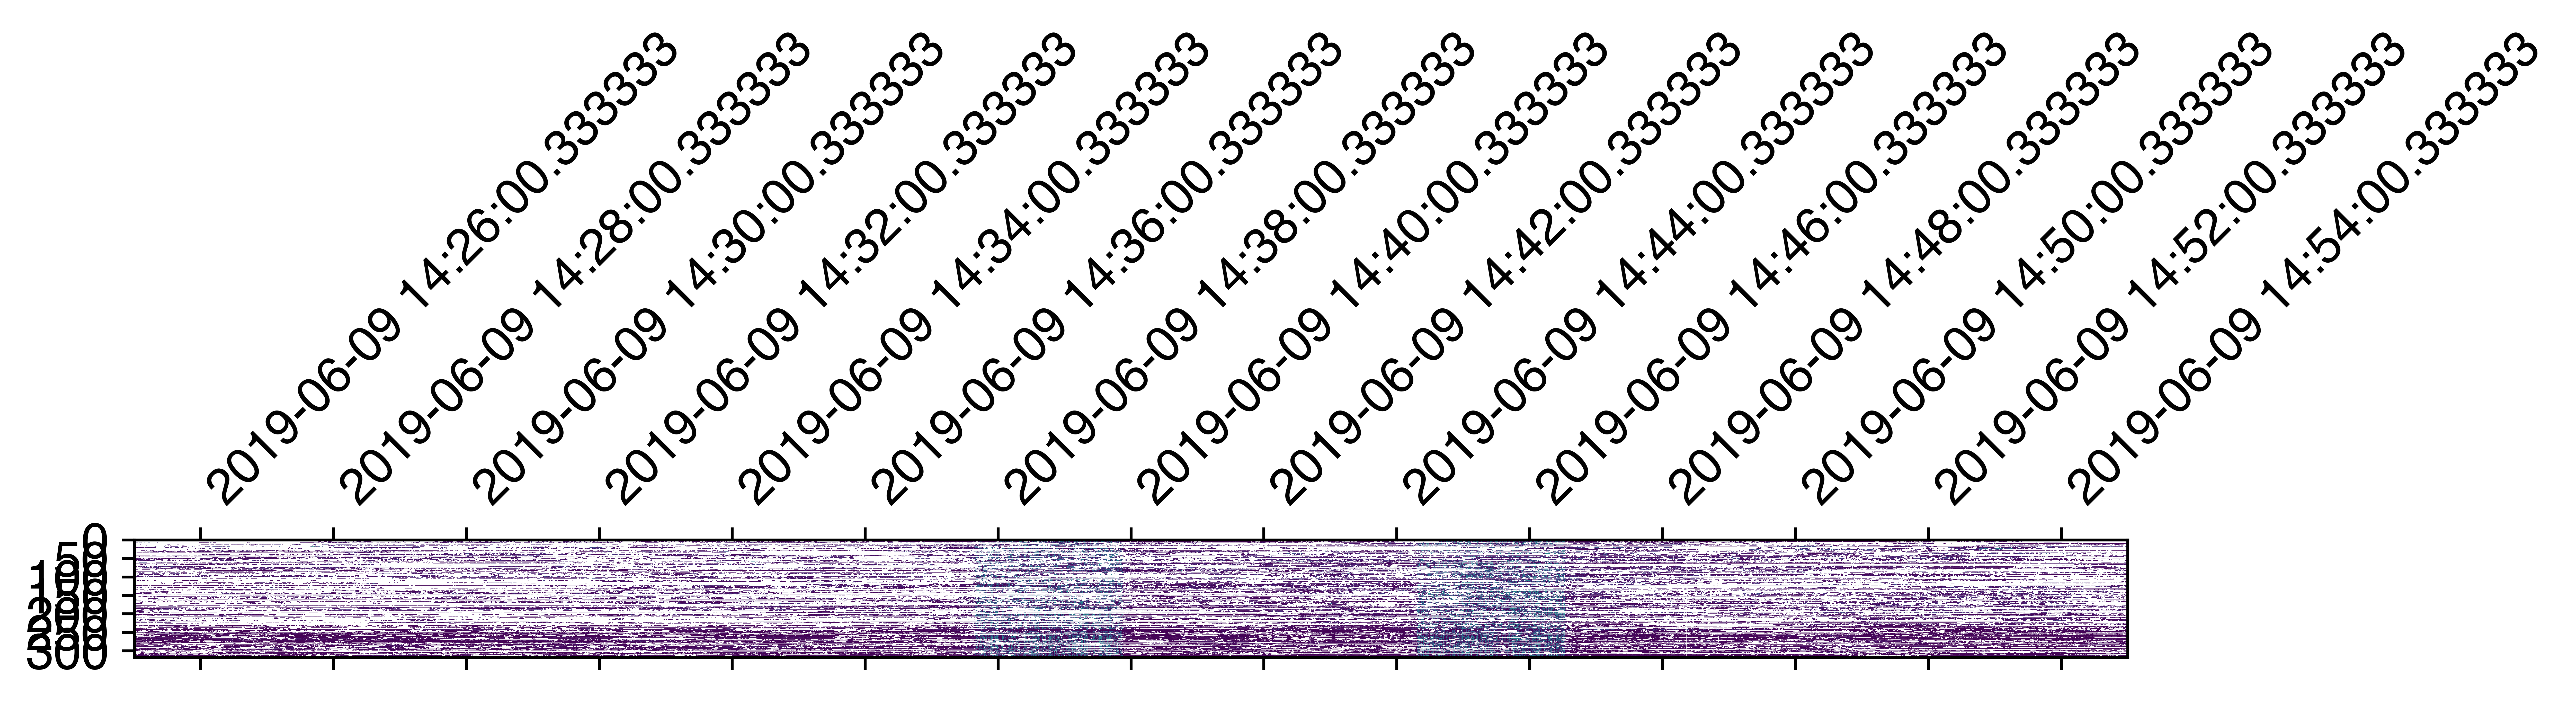

In [322]:
fig = plt.figure(figsize=(10,7),dpi=1000)

speed_thresh_frames = 1.5 # cm/s

# show binarized speed matrix
fast_bees_in_speed_mat = np.sort(list(set(fast_bees).intersection(speed_mat_frames.index)))
m = speed_mat_frames.loc[fast_bees_in_speed_mat] #>speed_thresh_frames
plt.matshow(m,fignum=fig.number)
divisions_per_day = int(divisions_per_day_frames)
offsetx = 2 + 59*3 # offset to put first tick at a five minute mark
skipx = divisions_per_day_frames//24//(60//2) # corresponds to ticks every two minutes
plt.xticks(range(m.shape[1])[offsetx::skipx], 
           [t for t in m.columns[offsetx::skipx]],rotation=45,ha='left');

plt.subplots_adjust(bottom=0.05,top=0.5)
plt.savefig('240528_preliminary_speed_burst_data_frames_fast_bees.pdf')

In [332]:
fast_bees

Index([ 415,  577,  612,  623,  644,  714,  756,  816,  835,  847,
       ...
        554, 1384, 1358,  591, 1994, 2065, 1245, 1467, 1703, 2018],
      dtype='int64', name='uid', length=318)

<Axes: >

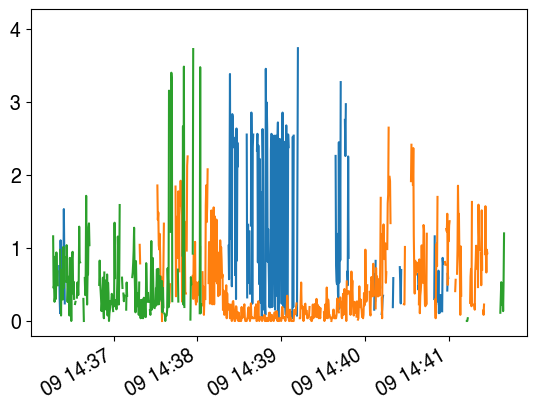

In [338]:
speed_mat_frames.loc[415].iloc[2000:3000].plot()
speed_mat_frames.loc[577].iloc[2000:3000].plot()
speed_mat_frames.loc[623].iloc[2000:3000].plot()